In [1]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor  # Import RandomForestRegressor

from sklearn.metrics import mean_pinball_loss, mean_squared_error
from sklearn.metrics import r2_score


In [2]:
import numpy as np
import random
# Set random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)

In [3]:
Variables_level_url = "https://raw.githubusercontent.com/Raziye-Aghapour/RET_GreenBuilding/main/RET%20-Variables_level.csv"
Factors_levels = pd.read_csv(Variables_level_url)
Factors_levels

,variable,description,type,values
0,1,RoofExtFinish,Categorical,"Light,Dark,Uncolored,Aluminum Paint"
1,2,RoofExteriorInsulation,Numerical-Continuous,"0,4,36,35,24,20,12,9,30,28,42,18,14,8,6"
2,3,RoofAddlInsulation,Numerical-Continuous,"0,19,49,38,11,3,30,13,60,21,7,15,26"
3,4,AGWExtFinish,Categorical,"Light,Dark,Uncolored,Medium"
4,5,AGWExteriorInsulation,Numerical-Continuous,"10.5,21,2,1.3,7,14,4,12,0,18,6,9,8"
5,6,AGWInteriorInsulation,Numerical-Continuous,"4,0,7,6"
6,7,AGWAddlInsulation,Numerical-Continuous,"13,19,3,11,7,15,0"
7,8,CeilingsBattInsulation,Numerical-Continuous,"0,21,15,13,7,60,49,45,11,38,3,26,30,19"
8,9,VerticalWallsBattInsulation,Numerical-Continuous,"19,21,0,11,13,30"
9,10,GlassCategory,Categorical,"Double Low E,Triple Low E,Single Low E,Quadrup..."


In [4]:
# classify our features between the ones that are fixed and the ones that will be
# part of the optimization problem

Cat_features=Factors_levels[Factors_levels['type'] == 'Categorical']['description'].tolist()

Num_features=Factors_levels[Factors_levels['type'] == 'Numerical-Continuous']['description'].tolist()


print(len(Cat_features))

10


In [5]:


def build_model_and_encoded_data(link, Cat_features, tree_params):
    # Read data from the provided link
    Cost = pd.read_excel(link, engine='openpyxl')
    features = Cost.columns.tolist()[:-1]
    target = Cost.columns.tolist()[-1]

    # Encode categorical variables
    column_transformer = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(sparse=False), Cat_features)
        ],
        remainder='passthrough'
    )
    transformed_data = column_transformer.fit_transform(Cost)
    new_columns = column_transformer.get_feature_names_out()
    encoded_Cost = pd.DataFrame(transformed_data, columns=new_columns)
    encoded_features = encoded_Cost.columns.tolist()[:-1]
    encoded_target = encoded_Cost.columns.tolist()[-1]

    # Split the data for training and testing
    X = encoded_Cost[encoded_features]
    y = encoded_Cost[encoded_target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.8, random_state=1
    )

    # Build Decision Tree Regressor model
    tree = DecisionTreeRegressor(**tree_params)  # Use DecisionTreeRegressor with tree_params
    tree_model = make_pipeline(tree)
    tree_model.fit(X_train, y_train)

    mse = mean_squared_error(y_test, tree_model.predict(X_test))
    print("The mean squared error (MSE) on test set: {:.4f}".format(mse))


   # Get R^2 from test data

    print(f"The R^2 value in the test set is {r2_score(y_test, tree_model.predict(X_test))}")

    # tree_model.fit(X, y)

    print(f"The R^2 value in the full dataset is {np.round(r2_score(y, tree_model.predict(X)),5)}")

    return tree_model, encoded_Cost


In [6]:
# Example usage:
DOE_url_HHP = "https://github.com/Raziye-Aghapour/RET_GreenBuilding/raw/main/RET%20-%20HHP%20Output.xlsx"
HHP = pd.read_excel(DOE_url_HHP, engine='openpyxl')


In [7]:


tree_params = {
    'criterion': 'squared_error',
    'splitter': 'best',
    'max_depth': 3,
    'min_samples_split': 8,
    'min_samples_leaf': 8,
    'max_features': 'auto',
    'random_state': 42
}


tree_HHP, encoded_HHP = build_model_and_encoded_data(DOE_url_HHP, Cat_features, tree_params)



The mean squared error (MSE) on test set: 576.9652
The R^2 value in the test set is 0.9182231285466353
The R^2 value in the full dataset is 0.73873


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


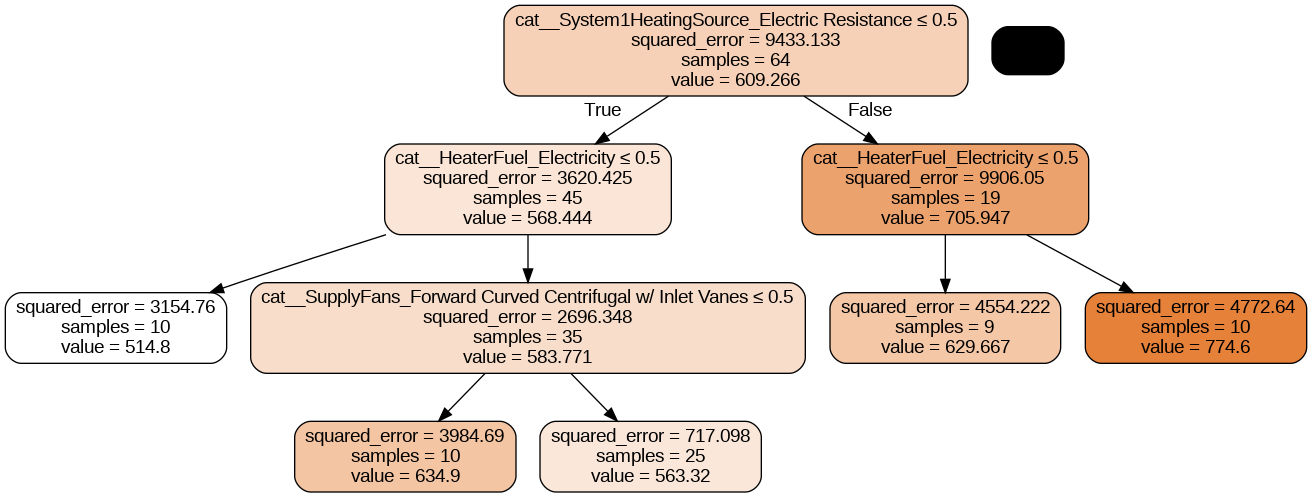

In [8]:
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image

# Export and visualize the decision tree
dot_data = export_graphviz(
    tree_HHP.named_steps['decisiontreeregressor'],
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    feature_names=encoded_HHP.columns.tolist()[:-1]  # Pass the one-hot encoded feature names
)

# Create a GraphViz graph from dot data
graph = graph_from_dot_data(dot_data)

# Convert the graph to PNG image
png = graph.create_png()

# Save (optional)
from pathlib import Path
Path('./out.png').write_bytes(png)

# Display
Image(png)

In [9]:
##Grouping the categorical features


from collections import defaultdict

# Initialize a defaultdict to hold lists of one-hot encoded variables for each original category
one_hot_to_original_mapping = defaultdict(list)

# Assuming 'encoded_features' is a list of your one-hot encoded feature names
# and 'Cat_features' is a list of your original categorical feature names
for feature_name in encoded_HHP.columns.tolist()[:-1]:
    for cat_var in Cat_features:
        if cat_var in feature_name:
            one_hot_to_original_mapping[cat_var].append(feature_name)
            break  # Assuming each one-hot encoded feature can only belong to one category

# Now, one_hot_to_original_mapping maps from original categories to lists of one-hot encoded feature names
print(one_hot_to_original_mapping)

defaultdict(<class 'list'>, {'RoofExtFinish': ['cat__RoofExtFinish_Aluminum Paint', 'cat__RoofExtFinish_Dark', 'cat__RoofExtFinish_Light', 'cat__RoofExtFinish_Uncolored'], 'AGWExtFinish': ['cat__AGWExtFinish_Dark', 'cat__AGWExtFinish_Light', 'cat__AGWExtFinish_Medium', 'cat__AGWExtFinish_Uncolored'], 'GlassCategory': ['cat__GlassCategory_Double Low E', 'cat__GlassCategory_Quadruple Low E', 'cat__GlassCategory_Single Low E', 'cat__GlassCategory_Triple Low E'], 'GlassTypeEmissivity': ['cat__GlassTypeEmissivity_High', 'cat__GlassTypeEmissivity_Low'], 'FrameType': ['cat__FrameType_AlumwBrkFixedMtlSpacer', 'cat__FrameType_FiberglassFixedMlt spacer', 'cat__FrameType_ReinforcedVinylFixedMtlSpacer', 'cat__FrameType_WoofFixedMltSpacer'], 'System1HeatingSource': ['cat__System1HeatingSource_DX Coils', 'cat__System1HeatingSource_Electric Resistance'], 'System1SystemType': ['cat__System1SystemType_Packaged VVT', 'cat__System1SystemType_Split System Single Zone'], 'SupplyFans': ['cat__SupplyFans_For

In [10]:
%pip install gurobipy
%pip install gurobipy_pandas
%pip install gurobi-machinelearning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.8/70.8 kB 2.2 MB/s eta 0:00:00


In [11]:
from gurobi_ml import add_predictor_constr
import gurobipy as gp
import gurobipy_pandas as gppd

In [12]:
m = gp.Model("Green_budling_GB")

Restricted license - for non-production use only - expires 2025-11-24


In [13]:
# Add binary variables for the one-hot encoded columns
binary_columns = [col for col in encoded_HHP.columns if col.startswith('cat__')]
for column in binary_columns:
    m.addVar(vtype=gp.GRB.BINARY, name=column)

# Add continuous variables for the original numerical variables
# We use the prefix 'remainder__' to identify the original numerical columns
continuous_columns = [col for col in encoded_HHP[encoded_HHP.columns.tolist()[:-1]] if col.startswith('remainder__')]
for column in continuous_columns:
    # Extract the original column name (without 'remainder__' prefix)
    original_column_name = column.replace('remainder__', '')
    # Define bounds based on the min and max values of the original column
    lb = HHP[original_column_name].min()
    ub = HHP[original_column_name].max()
    # Add the variable to the model with the defined bounds
    m.addVar(lb=lb, ub=ub, vtype=gp.GRB.CONTINUOUS, name=column)

# Update the model to integrate the new variables
# Now, your model has the necessary decision variables defined as per your dataset.
m.update()

In [14]:
# Assuming m is your Gurobi model
variables_dict = {var.VarName: var for var in m.getVars()}
# Create a DataFrame with a single row containing the Gurobi variables
variables_df = pd.DataFrame(variables_dict, index=[0])

In [15]:
HHP_approx = m.addVar(name="HHP_approx")


m.update()

In [16]:
m.setObjective(HHP_approx, gp.GRB.MINIMIZE)

In [17]:
variables_df[encoded_HHP.columns.tolist()[:-1]]

,cat__RoofExtFinish_Aluminum Paint,cat__RoofExtFinish_Dark,cat__RoofExtFinish_Light,cat__RoofExtFinish_Uncolored,cat__AGWExtFinish_Dark,cat__AGWExtFinish_Light,cat__AGWExtFinish_Medium,cat__AGWExtFinish_Uncolored,cat__GlassCategory_Double Low E,cat__GlassCategory_Quadruple Low E,...,cat__HeaterType_instantaneous,remainder__RoofExteriorInsulation,remainder__RoofAddlInsulation,remainder__AGWExteriorInsulation,remainder__AGWInteriorInsulation,remainder__AGWAddlInsulation,remainder__CeilingsBattInsulation,remainder__VerticalWallsBattInsulation,remainder__GlassTypeThickness,remainder__GlassTypeSpacing
0,<gurobi.Var cat__RoofExtFinish_Aluminum Paint>,<gurobi.Var cat__RoofExtFinish_Dark>,<gurobi.Var cat__RoofExtFinish_Light>,<gurobi.Var cat__RoofExtFinish_Uncolored>,<gurobi.Var cat__AGWExtFinish_Dark>,<gurobi.Var cat__AGWExtFinish_Light>,<gurobi.Var cat__AGWExtFinish_Medium>,<gurobi.Var cat__AGWExtFinish_Uncolored>,<gurobi.Var cat__GlassCategory_Double Low E>,<gurobi.Var cat__GlassCategory_Quadruple Low E>,...,<gurobi.Var cat__HeaterType_instantaneous>,<gurobi.Var remainder__RoofExteriorInsulation>,<gurobi.Var remainder__RoofAddlInsulation>,<gurobi.Var remainder__AGWExteriorInsulation>,<gurobi.Var remainder__AGWInteriorInsulation>,<gurobi.Var remainder__AGWAddlInsulation>,<gurobi.Var remainder__CeilingsBattInsulation>,<gurobi.Var remainder__VerticalWallsBattInsula...,<gurobi.Var remainder__GlassTypeThickness>,<gurobi.Var remainder__GlassTypeSpacing>


In [18]:
from gurobi_ml import add_predictor_constr

# Assuming gbr_model is your trained gradient boosting model
# And assuming feats is a list of feature names used by your model, which should match the column names in variables_df

# Use add_predictor_constr to add your model to the optimization problem
pred_constr = add_predictor_constr(m, tree_HHP, variables_df[encoded_HHP.columns.tolist()[:-1]], HHP_approx)

# Update the model to integrate the new constraints
m.update()

pred_constr.print_stats()

Model for pipe:
5 variables
1 constraints
17 general constraints
Input has shape (1, 38)
Output has shape (1, 1)

Pipeline has 1 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
tree                  (1, 1)            5            1            0           17

--------------------------------------------------------------------------------


In [19]:
# Assuming 'm' is your Gurobi model
for cat_var, one_hot_vars in one_hot_to_original_mapping.items():
    # Sum the binary variables corresponding to the one-hot encoded categories of each original feature
    # Ensure that this sum is >= 1, meaning at least one category must be selected
    m.addConstr(gp.quicksum(m.getVarByName(var) for var in one_hot_vars) == 1, name=f"select_at_least_one_{cat_var}")

# Update the model to integrate the new constraints
m.update()

In [20]:
m.write('CART_opt.lp')


In [21]:

m.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 11 rows, 44 columns and 34 nonzeros
Model fingerprint: 0xc1765ab1
Model has 17 general constraints
Variable types: 10 continuous, 34 integer (34 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-01, 6e+01]
  RHS range        [1e+00, 1e+00]
  GenCon rhs range [5e-01, 8e+02]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 6 rows and 34 columns
Presolve time: 0.00s
Presolved: 5 rows, 10 columns, 13 nonzeros
Presolved model has 5 SOS constraint(s)
Variable types: 5 continuous, 5 integer (5 binary)

Root relaxation: objective 0.000000e+00, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl U

In [22]:
# Variable info
varInfo = [(v.varName, v.X, v.LB, v.UB) for v in m.getVars() ]
df = pd.DataFrame(varInfo)
df.columns=['Variable Name','Solution Value', 'LB','UB']
df.to_excel("variables.xlsx", index=False)
df_var = df.query('`Solution Value` > 0')
df.to_csv('out.csv')
df_var

,Variable Name,Solution Value,LB,UB
0,cat__RoofExtFinish_Aluminum Paint,1.000,0.000,1.00
4,cat__AGWExtFinish_Dark,1.000,0.000,1.00
8,cat__GlassCategory_Double Low E,1.000,0.000,1.00
12,cat__GlassTypeEmissivity_High,1.000,0.000,1.00
14,cat__FrameType_AlumwBrkFixedMtlSpacer,1.000,0.000,1.00
18,cat__System1HeatingSource_DX Coils,1.000,0.000,1.00
20,cat__System1SystemType_Packaged VVT,1.000,0.000,1.00
22,cat__SupplyFans_Forward Curved Centrifugal w/ ...,1.000,0.000,1.00
26,cat__HeaterFuel_Gas,1.000,0.000,1.00
27,cat__HeaterType_Storage,1.000,0.000,1.00


In [23]:
m.dispose()

In [24]:
# Initialize dictionary to store second dataset feature values
optimal_design = {}
# Populate dictionary with feature names and values from second dataset
for feature, values in variables_df.items():
    optimal_design[feature] = 0

# Convert DataFrame to dictionary
df_dict = df_var.set_index('Variable Name')['Solution Value'].to_dict()


# Update values in your dictionary if there is a common key
for key in optimal_design.keys():
    if key in df_dict:
        optimal_design[key] = df_dict[key]

# Convert dictionary to DataFrame with one row and columns as variable names
optimal_design = pd.DataFrame(optimal_design, index=[0])

# print(optimal_design)
print(tree_HHP.predict(optimal_design))

[514.8]
